# Title: BigQuery 
## Purpose: Test BigQuery in Jupyter
## Author: mjz

`./run_boromir.py --bigquery_table='cloud-performance-tool:test_notebook_bq.test2'`


In [1]:
%%bash 
python --version

Python 3.6.8


In [23]:
ds = 'test_notebook_bq'
tab = 'test1'
proj = 'cloud-performance-tool'
tbl2_full = '`cloud-performance-tool.test_notebook_bq.test2`'
key_loc = '/home/toor/.google/smu-benchmarking-7de5dd11902f.json'

In [3]:
import os


In [4]:

from google.cloud import bigquery
%reload_ext google.cloud.bigquery

import pandas as pd
import pandas_gbq

`gcloud auth application-default login`
to get library auth setup from gcloud

In [13]:
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_loc # bq_client needs this (svc_acct auth)
# bigquery_client = bigquery.Client(project=proj) # 

pandas_gbq.context.project = proj
pandas_gbq.context.dialect = 'standard'

In [1]:
%%bigquery
SELECT * FROM `cloud-performance-tool.test_notebook_bq.test2`
where labels != ''

UsageError: Cell magic `%%bigquery` not found.


In [26]:
%%bigquery df
SELECT * FROM `cloud-performance-tool.test_notebook_bq.test2`



In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 11 columns):
sample_uri      38 non-null object
run_uri         38 non-null object
owner           38 non-null object
official        38 non-null bool
timestamp       38 non-null float64
unit            38 non-null object
test            38 non-null object
product_name    38 non-null object
value           38 non-null float64
labels          38 non-null object
metric          38 non-null object
dtypes: bool(1), float64(2), object(8)
memory usage: 3.1+ KB


In [28]:
df.head()

,sample_uri,run_uri,owner,official,timestamp,unit,test,product_name,value,labels,metric
0,31302b02-7e1e-445a-90d0-32393bb84495,c3b23282,cat-dog,False,1.582659e+09,effs,metf_tm,py_mulval,0.616000,"|citation:Rodolphe Ortalo, Yves Deswarte, and ...",metf_tm
1,07ba50de-e979-4eaa-8dd9-6c9795ab2c53,c3b23282,cat-dog,False,1.582659e+09,weeks,mttf,py_mulval,52.033500,"|attack_graph_name:single_host_1|,|citation:Ma...",mttf
2,c0d62171-7cdf-4c5a-a67e-a5495977e078,c3b23282,cat-dog,False,1.582659e+09,weeks,shortest_path_cumulative,py_mulval,153.467000,"|all_shortest_paths:[('0', '13', '5', '3', '1'...",shortest_path_cumulative
3,960a2bb7-5443-47da-80ad-dc2de8164323,c3b23282,cat-dog,False,1.582659e+09,seconds,metf_tm,py_mulval,0.021333,,End to End Runtime
4,3b0887b3-03f3-4126-9d46-3b9480694250,c3b23282,cat-dog,False,1.582659e+09,seconds,mttf,py_mulval,0.011740,,End to End Runtime


In [45]:
%%bigquery df
#standardSQL
SELECT thedate, test, value, unit, labels
#   concat(sending_region, '-', receiving_region) as regions
FROM (
  SELECT
#     value,
    TIMESTAMP_TRUNC(TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)), DAY) AS thedate,
    test, value, unit, labels
#     REGEXP_EXTRACT(labels, r'\|vm_1_zone:(.*?)\|') AS sending_zone,
#     REGEXP_EXTRACT(labels, r'\|vm_2_zone:(.*?)\|') AS receiving_zone,
#     REGEXP_EXTRACT(labels, r'\|vm_1_zone:us-(.*?)-.*?\|') AS sending_region,
#     REGEXP_EXTRACT(labels, r'\|vm_2_zone:us-(.*?)-.*?\|') AS receiving_region
  FROM
    `cloud-performance-tool.test_notebook_bq.test2`)
#   WHERE
#     test = 'ping'
#     AND metric = 'Average Latency' )
# WHERE
  #sending_zone != receiving_zone
#   sending_region != receiving_region
# group by thedate, sending_region, receiving_region


In [48]:
df.labels[0]

'|citation:None|,|cite_key:None|,|metric_name:None|,|metric_summary:None|,|metric_unit:None|,|metric_usage:None|,|run_number:0|'

In [208]:
%%bigquery df
#standardSQL
SELECT
  EXTRACT(HOUR FROM thedate) as HoD,
  EXTRACT(DAYOFWEEK FROM thedate) as DoW,
  value,
  sending_zone
FROM (
  SELECT
    value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    REGEXP_EXTRACT(labels, r'\|vm_1_zone:(.*?)\|') AS sending_zone,
    REGEXP_EXTRACT(labels, r'\|vm_2_zone:(.*?)\|') AS receiving_zone
  FROM
    `smu-benchmarking.daily_tests.daily_1`
  WHERE
    test = 'ping'
    AND metric = 'Average Latency' 
    and REGEXP_EXTRACT(labels, r'\|ip_type:(.*?)\|') = 'internal'
    and REGEXP_EXTRACT(labels, r'\|vm_2_zone:us-(.*?)-.*?\|') = 'east1'
    )
WHERE
  sending_zone = receiving_zone
    AND date(thedate) BETWEEN date("2019-02-01") and date("2020-02-01")
-- group by thedate, sending_zone, hod, dow, value

ORDER BY thedate DESC


In [209]:
df.info()
grouped =df.groupby(['DoW', 'HoD']).mean()['value']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 4 columns):
HoD             1650 non-null int64
DoW             1650 non-null int64
value           1650 non-null float64
sending_zone    1650 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 51.7+ KB


In [226]:
# fig, ax = plt.subplots(figsize=(15,7))
# grouped.plot( legend=True).unstack().plot(ax=ax)
grouped.info()
# grouped =df.groupby(['DoW', 'HoD']).count()
# grouped.plot().unstack()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 132 entries, (1, 0) to (7, 22)
Data columns (total 2 columns):
value           132 non-null int64
sending_zone    132 non-null int64
dtypes: int64(2)
memory usage: 2.7 KB


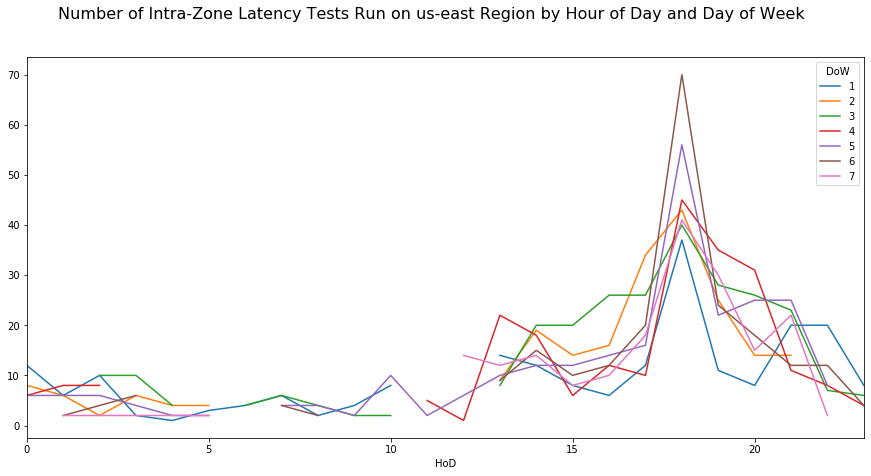

In [231]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
# grouped.plot( legend=True).unstack().plot(ax=ax)
fig.suptitle('Number of Intra-Zone Latency Tests Run on us-east Region by Hour of Day and Day of Week', fontsize=16)
df.groupby([ 'HoD', 'DoW']).count()['value'].unstack().plot(ax=ax)

# data.groupby(['date','type']).count()['amount'].unstack().plot(ax=ax)
# df.groupby('DoW').plot(ax=ax)

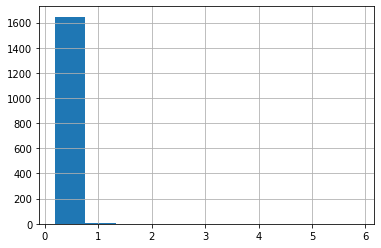

In [233]:
df['value'].hist()

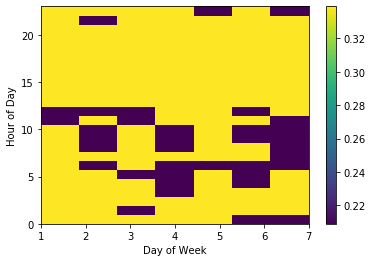

In [214]:
plt.hist2d(x=df['DoW'], y=df['HoD'], bins=(7, 24), data=df['value'], vmin=df['value'].quantile(.01), vmax=df['value'].quantile(.99))
plt.colorbar()
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.show()

In [215]:
df.describe()

,HoD,DoW,value
count,1650.000000,1650.000000,1650.000000
mean,15.638182,3.936364,0.261195
std,5.587552,1.925274,0.144619
min,0.000000,1.000000,0.185000
25%,14.000000,2.000000,0.239000
50%,18.000000,4.000000,0.252000
75%,19.000000,6.000000,0.270750
max,23.000000,7.000000,5.881000


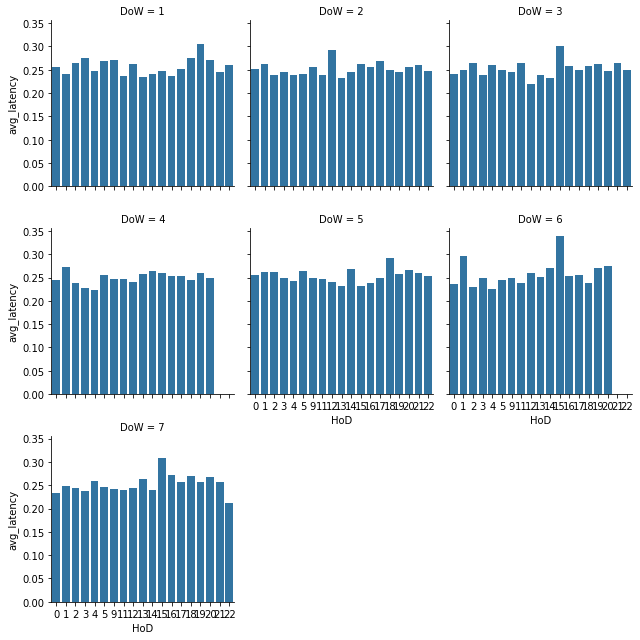

In [179]:
import pandas as pd
import seaborn as sns

# make some data
# date = pd.date_range('today', periods=100, freq='2.5H')

# put in dataframe
# df = pd.DataFrame({
#     'date' : date
# })

# create day_of_week and hour columns
# df['down'] = df['DoW']
# df['hour'] = df['HoD']

# create facet grid
g = sns.FacetGrid(data=df.groupby([
    'DoW',
    'HoD'
]).mean()['value'].to_frame(name='avg_latency').reset_index(), col='DoW',  col_wrap=3)

# map barplot to each subplot
g.map(sns.barplot, 'HoD', 'avg_latency');

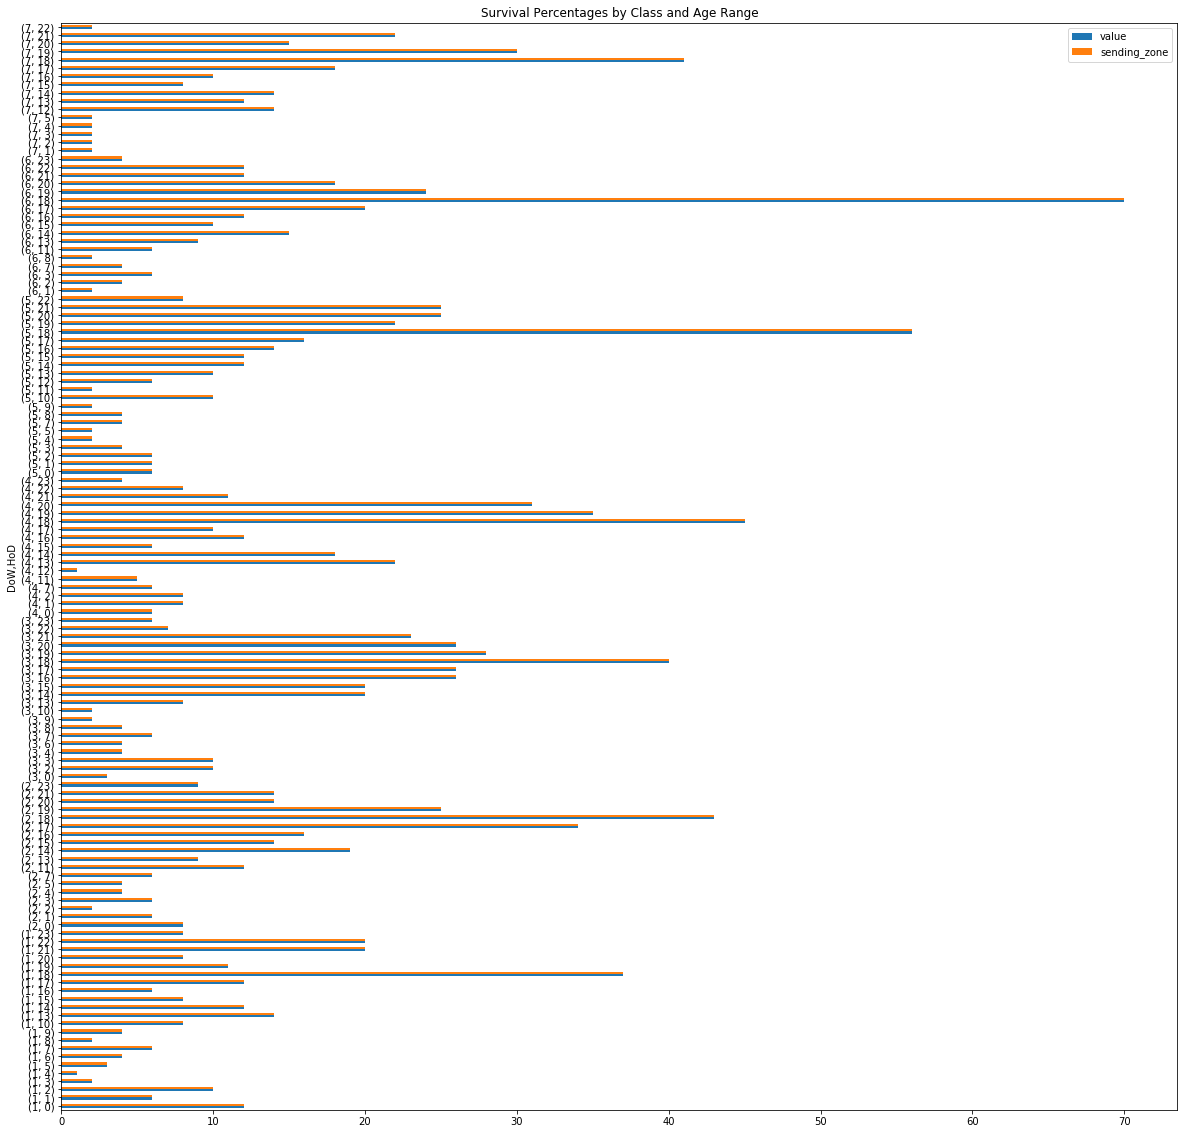

In [237]:

ax = grouped.plot(kind='barh', figsize=(20,20))
plt.title('Survival Percentages by Class and Age Range')
plt.show()